In [216]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tabulate import tabulate

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from skmultilearn.model_selection import IterativeStratification

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import seaborn as sns

# 1) Experimentando Diferentes conjuntos de dados

## 1.1) Pré-processamento

### 1.1.1) Flatten train 

In [217]:
def config_flatten_train(y_train, y_test): 
    y_train_flatten = y_train.values.ravel()
    y_test_flatten = y_test.values.ravel()

    return y_train_flatten, y_test_flatten

### 1.1.2) Configurando LabelEncoder

In [218]:
def config_label_encoder(y_train, y_test):
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    return y_train_encoded, y_test_encoded

### 1.1.3) Padronizar as características (normalização)

In [219]:
def config_start_scaler(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled

### 1.1.4) Pré-processando dados

In [220]:
def config_one_hot(y_train_encoded, y_test_encoded):
    num_classes = len(np.unique(y_train_encoded))

    # Converta as classes em vetores one-hot (para a camada de saída)
    y_train_onehot = to_categorical(y_train_encoded, num_classes=num_classes)
    y_test_onehot = to_categorical(y_test_encoded, num_classes=num_classes)

    return y_train_onehot, y_test_onehot

## 1.2) Carregar os dados de treinamento e teste

In [221]:
X_train_array = []
y_train_array = []
X_test_array = []
y_test_array = []  

def get_data_from_conjunto(conjunto: int):      

    X_train = pd.read_csv(f'../Dados/RedesNeurais/Conjunto_{conjunto+1}/X_train.csv')
    y_train = pd.read_csv(f'../Dados/RedesNeurais/Conjunto_{conjunto+1}/y_train.csv')
    X_test = pd.read_csv(f'../Dados/RedesNeurais/Conjunto_{conjunto+1}/X_test.csv')
    y_test = pd.read_csv(f'../Dados/RedesNeurais/Conjunto_{conjunto+1}/y_test.csv')

    num_classes = len(np.unique(y_train))
    input = X_train.shape[1]
    
    y_train, y_test = config_flatten_train(y_train, y_test)
    y_train, y_test = config_label_encoder(y_train, y_test)
    # y_train, y_test = config_start_scaler(X_train, X_test)
    y_train, y_test = config_one_hot(y_train, y_test)

    X_train_array.append(X_train)
    y_train_array.append(y_train)
    X_test_array.append(X_test)
    y_test_array.append(y_test)

    return num_classes, input, X_train_array, y_train_array, X_test_array, y_test_array

## 1.3) Montando rede

In [222]:
def build_neural_network(num_classes, input):

    neuralNetwork = Sequential()
    neuralNetwork.add(Dense(64, input_dim=input, activation='relu'))
    neuralNetwork.add(Dense(32, activation='relu'))
    neuralNetwork.add(Dense(num_classes, activation='softmax'))  

    neuralNetwork.summary()

    return neuralNetwork

## 1.4) Treinando modelo

In [223]:
def kfold_cross_validation(X_train, y_train, num_classes, input_dim):

    
    kfold = IterativeStratification(n_splits=5)

    acuracias = []
    precisoes = []
    revocacoes = []
    f1_scores = []

    i = 1

    best_acuracia = 0.0
    best_model = None

    for train_index, test_index in kfold.split(X_train, y_train):
        print(f'\nFold {i}')

        X_treino_fold, X_teste_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_treino_fold, y_teste_fold = y_train[train_index], y_train[test_index]

        X_treino_fold = X_treino_fold.astype('float32')
        y_treino_fold = y_treino_fold.astype('float32')
        X_teste_fold = X_teste_fold.astype('float32')

        neuralNetwork = build_neural_network(num_classes, input_dim)
        neuralNetwork.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        neuralNetwork.fit(X_treino_fold, y_treino_fold, epochs=100, batch_size=32)

        y_pred = neuralNetwork.predict(X_teste_fold)

        y_pred_labels = np.argmax(y_pred, axis=1)
        y_teste_labels = np.argmax(y_teste_fold, axis=1)

        acuracia = accuracy_score(y_teste_labels, y_pred_labels)
        precisao = precision_score(y_teste_labels, y_pred_labels, average='weighted')
        revocacao = recall_score(y_teste_labels, y_pred_labels, average='weighted')
        f1 = f1_score(y_teste_labels, y_pred_labels, average='weighted')

        acuracias.append(acuracia)
        precisoes.append(precisao)
        revocacoes.append(revocacao)
        f1_scores.append(f1)

        # Check if the current model has the best F1-score
        if acuracia > best_acuracia:
            best_acuracia = acuracia
            best_model = neuralNetwork

        i = i + 1

    # Calculate mean and standard deviation
    media_acuracias = np.mean(acuracias)
    media_precisoes = np.mean(precisoes)
    media_revocacoes = np.mean(revocacoes)
    media_f1_scores = np.mean(f1_scores)

    desvio_padrao_acuracias = np.std(acuracias)
    desvio_padrao_precisoes = np.std(precisoes)
    desvio_padrao_revocacoes = np.std(revocacoes)
    desvio_padrao_f1_scores = np.std(f1_scores)

    # Display results
    print('\n---')
    for j in range(len(acuracias)):
        print(f'Fold {j + 1}:')
        print(f'Acurácia: {acuracias[j]}')
        print(f'Precisão: {precisoes[j]}')
        print(f'Revocação: {revocacoes[j]}')
        print(f'F1-Score: {f1_scores[j]}')
        print('---')

    print('\nMédias e Desvios Padrão Gerais:')
    print("----------------------------------------------------------------")
    print(f'Média Acurácias: {media_acuracias}')
    print(f'Desvio Padrão Acurácias: {desvio_padrao_acuracias}\n')
    print(f'Média Precisões: {media_precisoes}')
    print(f'Desvio Padrão Precisões: {desvio_padrao_precisoes}\n')
    print(f'Média Revocações: {media_revocacoes}')
    print(f'Desvio Padrão Revocações: {desvio_padrao_revocacoes}\n')
    print(f'Média F1-Scores: {media_f1_scores}')
    print(f'Desvio Padrão F1-Scores: {desvio_padrao_f1_scores}\n')

    return media_acuracias, media_precisoes, media_revocacoes, media_f1_scores, best_model

## 1.5) Carregando dados e treinando (Cross validation)

In [224]:
conjuntos = 10
resultados_acuracia = []
resultados_precisao = []
resultados_revocacao = []
resultados_f1 = []
best_models = []

for i in range(conjuntos):
    print(f'\nConjunto {i + 1}')
    num_classes, input, X_train_array, y_train_array, X_test_array, y_test_array = get_data_from_conjunto(i)

    media_acuracia, media_precisao, media_revocacao, media_f1, best_model = kfold_cross_validation(X_train_array[i], y_train_array[i], num_classes, input)

    resultados_acuracia.append(media_acuracia)
    resultados_precisao.append(media_precisao)
    resultados_revocacao.append(media_revocacao)
    resultados_f1.append(media_f1)
    best_models.append(best_model)


Conjunto 1

Fold 1
Model: "sequential_206"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_618 (Dense)           (None, 64)                320       
                                                                 
 dense_619 (Dense)           (None, 32)                2080      
                                                                 
 dense_620 (Dense)           (None, 3)                 99        
                                                                 
Total params: 2499 (9.76 KB)
Trainable params: 2499 (9.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100


18/18 [==============================] - 0s 941us/step - loss: 1.1242 - accuracy: 0.4464
Epoch 2/100
18/18 [==============================] - 0s 882us/step - loss: 0.9410 - accuracy: 0.5071
Epoch 3/100
18/18 [==============================] - 0s 824us/step - loss: 0.9331 - accuracy: 0.5071
Epoch 4/100
18/18 [==============================] - 0s 882us/step - loss: 0.9252 - accuracy: 0.5071
Epoch 5/100
18/18 [==============================] - 0s 941us/step - loss: 0.9171 - accuracy: 0.5071
Epoch 6/100
18/18 [==============================] - 0s 1ms/step - loss: 0.9087 - accuracy: 0.5071
Epoch 7/100
18/18 [==============================] - 0s 941us/step - loss: 0.8979 - accuracy: 0.5071
Epoch 8/100
18/18 [==============================] - 0s 824us/step - loss: 0.8917 - accuracy: 0.5071
Epoch 9/100
18/18 [==============================] - 0s 824us/step - loss: 0.8853 - accuracy: 0.5125
Epoch 10/100
18/18 [==============================] - 0s 882us/step - loss: 0.8689 - accuracy: 0.5107
Epo

## 1.6) Analisando resultados gerais

In [225]:
# Calculate the overall mean
overall_mean_acuracia = sum(resultados_acuracia) / len(resultados_acuracia)
overall_mean_precisao = sum(resultados_precisao) / len(resultados_precisao)
overall_mean_revocacao = sum(resultados_revocacao) / len(resultados_revocacao)
overall_mean_f1 = sum(resultados_f1) / len(resultados_f1)

# Create a DataFrame
data = {
    'Acurácia': [overall_mean_acuracia],
    'Precisão': [overall_mean_precisao],
    'Revocação': [overall_mean_revocacao],
    'F1-Score': [overall_mean_f1]
}

df = pd.DataFrame(data)

# Display the table
print(df)

   Acurácia  Precisão  Revocação  F1-Score
0  0.964295   0.96588   0.964295  0.964242


## 1.7) Predição, Matriz de confusão e Métricas de eficácia

----------------------------------------------------------------
Eficácia do conjunto 1
10/10 [==============================] - 0s 666us/step


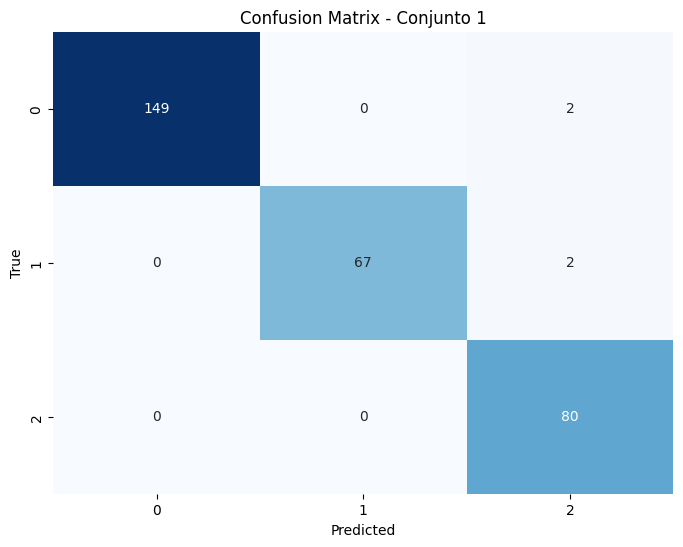

Acurácia no conjunto de teste: 98.67%

Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       151
           1       1.00      0.97      0.99        69
           2       0.95      1.00      0.98        80

    accuracy                           0.99       300
   macro avg       0.98      0.99      0.98       300
weighted avg       0.99      0.99      0.99       300


----------------------------------------------------------------

Eficácia do conjunto 2
10/10 [==============================] - 0s 667us/step


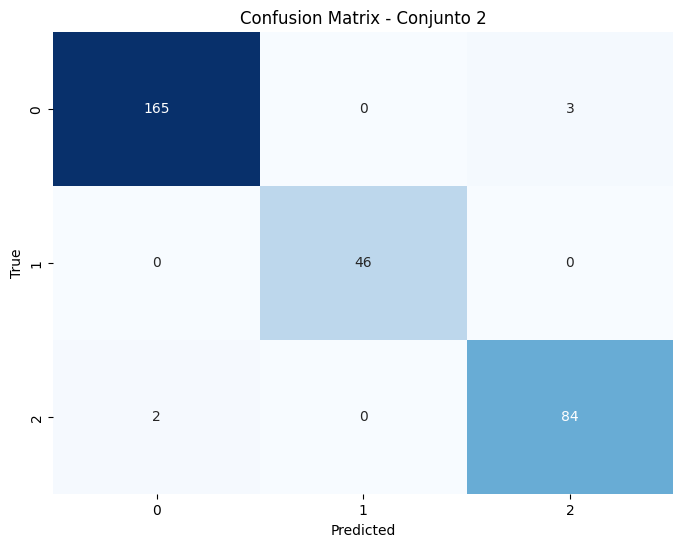

Acurácia no conjunto de teste: 98.33%

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       168
           1       1.00      1.00      1.00        46
           2       0.97      0.98      0.97        86

    accuracy                           0.98       300
   macro avg       0.98      0.99      0.99       300
weighted avg       0.98      0.98      0.98       300


----------------------------------------------------------------

Eficácia do conjunto 3
10/10 [==============================] - 0s 778us/step


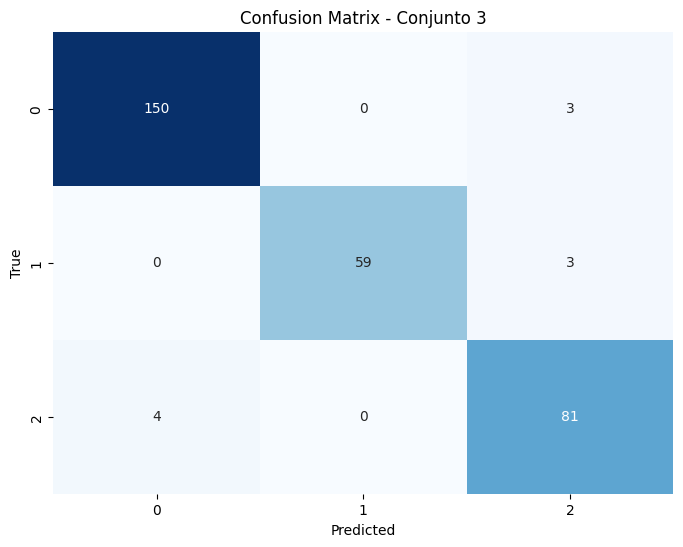

Acurácia no conjunto de teste: 96.67%

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       153
           1       1.00      0.95      0.98        62
           2       0.93      0.95      0.94        85

    accuracy                           0.97       300
   macro avg       0.97      0.96      0.96       300
weighted avg       0.97      0.97      0.97       300


----------------------------------------------------------------

Eficácia do conjunto 4
10/10 [==============================] - 0s 555us/step


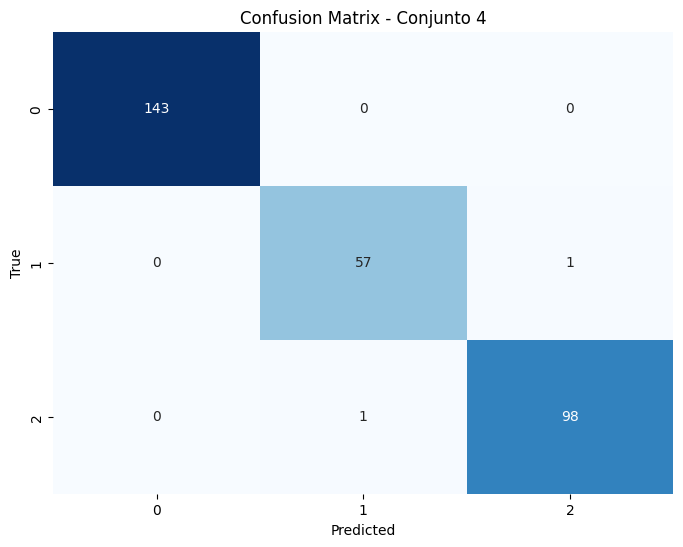

Acurácia no conjunto de teste: 99.33%

Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       143
           1       0.98      0.98      0.98        58
           2       0.99      0.99      0.99        99

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300


----------------------------------------------------------------

Eficácia do conjunto 5
10/10 [==============================] - 0s 667us/step


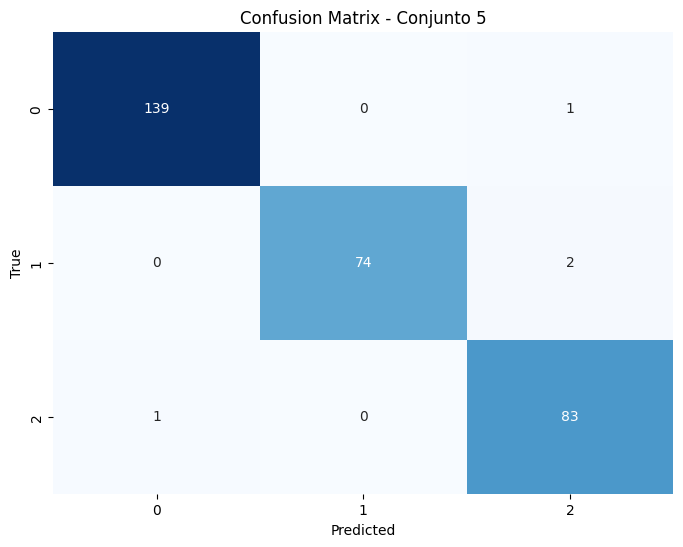

Acurácia no conjunto de teste: 98.67%

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       140
           1       1.00      0.97      0.99        76
           2       0.97      0.99      0.98        84

    accuracy                           0.99       300
   macro avg       0.99      0.98      0.99       300
weighted avg       0.99      0.99      0.99       300


----------------------------------------------------------------

Eficácia do conjunto 6
10/10 [==============================] - 0s 667us/step


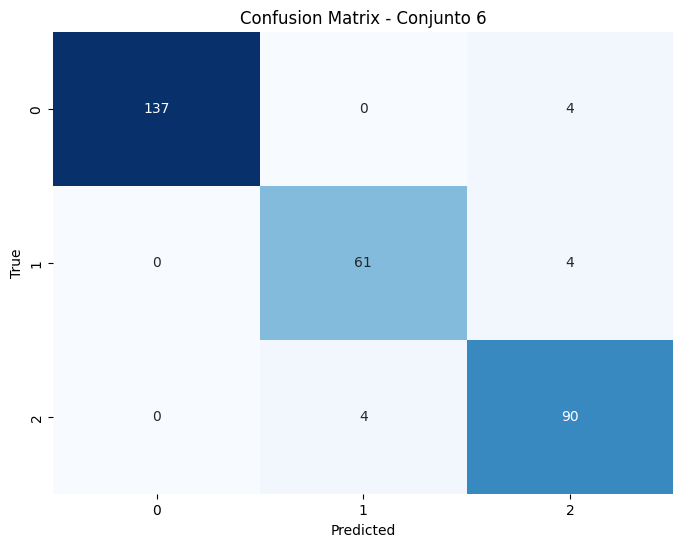

Acurácia no conjunto de teste: 96.00%

Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       141
           1       0.94      0.94      0.94        65
           2       0.92      0.96      0.94        94

    accuracy                           0.96       300
   macro avg       0.95      0.96      0.95       300
weighted avg       0.96      0.96      0.96       300


----------------------------------------------------------------

Eficácia do conjunto 7
10/10 [==============================] - 0s 666us/step


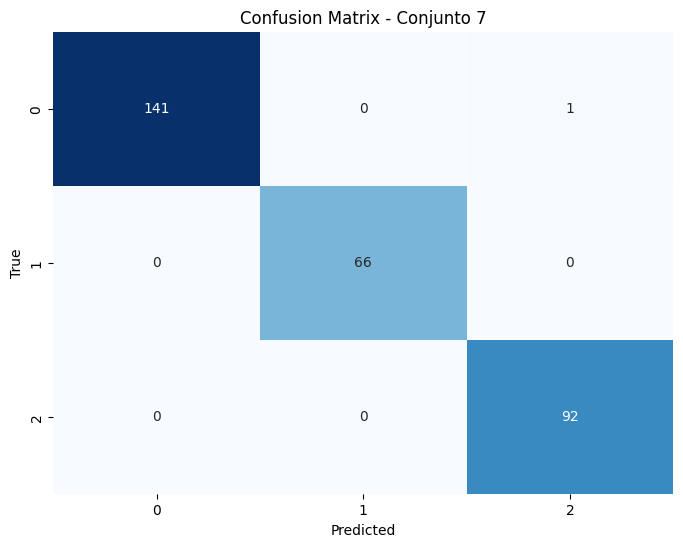

Acurácia no conjunto de teste: 99.67%

Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       142
           1       1.00      1.00      1.00        66
           2       0.99      1.00      0.99        92

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300


----------------------------------------------------------------

Eficácia do conjunto 8
10/10 [==============================] - 0s 667us/step


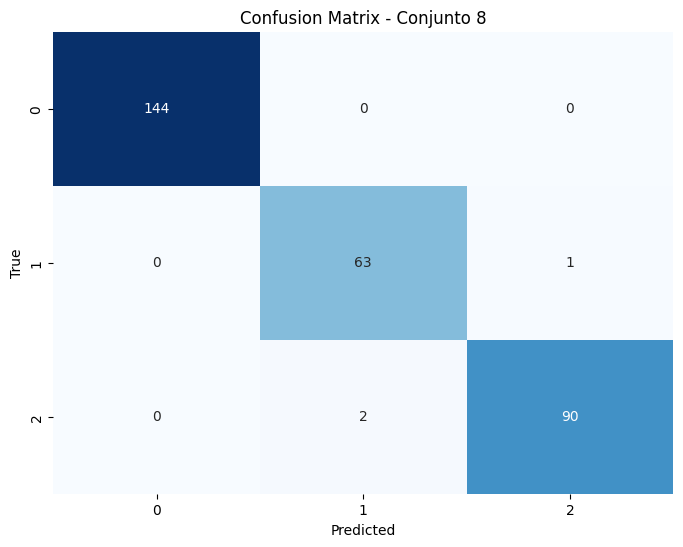

Acurácia no conjunto de teste: 99.00%

Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       144
           1       0.97      0.98      0.98        64
           2       0.99      0.98      0.98        92

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300


----------------------------------------------------------------

Eficácia do conjunto 9
10/10 [==============================] - 0s 667us/step


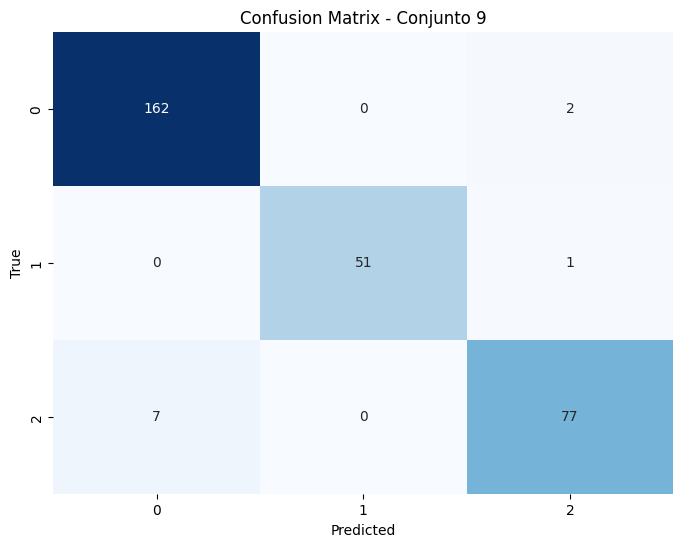

Acurácia no conjunto de teste: 96.67%

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       164
           1       1.00      0.98      0.99        52
           2       0.96      0.92      0.94        84

    accuracy                           0.97       300
   macro avg       0.97      0.96      0.97       300
weighted avg       0.97      0.97      0.97       300


----------------------------------------------------------------

Eficácia do conjunto 10
10/10 [==============================] - 0s 778us/step


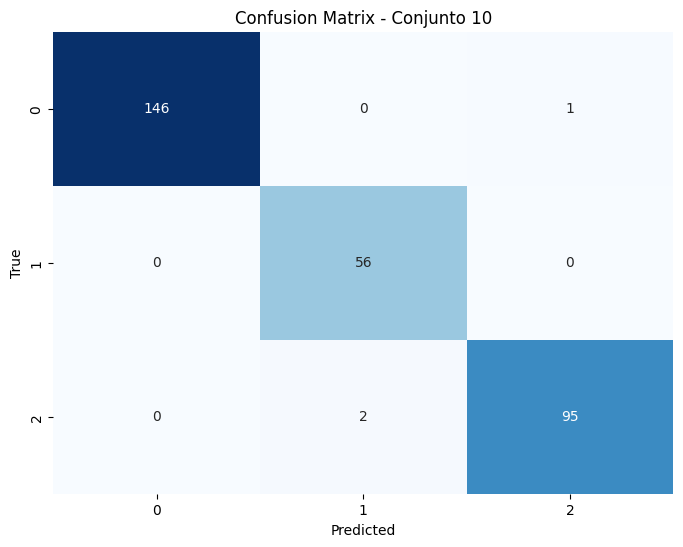

Acurácia no conjunto de teste: 99.00%

Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       147
           1       0.97      1.00      0.98        56
           2       0.99      0.98      0.98        97

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300


----------------------------------------------------------------



In [226]:
print("----------------------------------------------------------------")
# List to store average accuracies for each conjunto
average_accuracies = []
for i in range(conjuntos):
    print(f'Eficácia do conjunto {i + 1}')
    X_test = X_test_array[i]
    y_test = y_test_array[i]

    # Load the trained model for the current dataset
    neuralNetwork = best_models[i]

    # Ensure that the data type is float32
    X_test = X_test.astype('float32')

    # Make predictions on the test set
    y_pred = neuralNetwork.predict(X_test)

    # Convert predictions to labels
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_test_labels = np.argmax(y_test, axis=1)

    # Calculate the confusion matrix
    cm = confusion_matrix(y_test_labels, y_pred_labels)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - Conjunto {i + 1}')
    plt.show()

      # Calculate and print accuracy
    accuracy = accuracy_score(y_test_labels, y_pred_labels)

    # Append accuracy to the list
    average_accuracies.append(accuracy)
    
    print(f'Acurácia no conjunto de teste: {accuracy * 100:.2f}%\n')


    # Print classification report
    classification_rep = classification_report(y_test_labels, y_pred_labels)
    print(f'Relatório de Classificação:\n{classification_rep}')
    

    print('\n----------------------------------------------------------------\n')

## OBS: Verificando qual conjunto obteve o melhor resultado para ser usado nos testes dos parametros

In [227]:
# Find the index of the conjunto with the highest average accuracy
best_conjunto_index = np.argmax(average_accuracies)

# Print the conjunto with the highest average accuracy
print(f"\nO conjunto {best_conjunto_index + 1} obteve os melhores resultados.")


O conjunto 7 obteve os melhores resultados.


# 2) Experimentando as melhores configurações de parametros

## 2.1) Carregar os dados de treinamento e teste do melhor conjunto

In [243]:
# MUDAR ISSO -> ESCOLHER UM NUMERO ENTRE 1 A 10 E PEGAR AQUELE CONJUNTO

X_train = X_train_array[best_conjunto_index]
y_train = y_train_array[best_conjunto_index]
X_test = X_test_array[best_conjunto_index]
y_test = y_test_array[best_conjunto_index]

X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')

## 2.2) Experimentando diferentes redes neurais

In [245]:
architectures = [
    (32, 32),        # Exemplo de arquitetura 1
    (64, 32, 16),    # Exemplo de arquitetura 2
    (128, 64),       # Exemplo de arquitetura 3
]

hyperparameters = {
    'activation_function': ['relu', 'tanh', 'sigmoid'],
    'optimizer': ['adam', 'sgd', 'rmsprop'],
    'batch_size': [32, 64, 128]
}

best_model = None
best_accuracy = 0.0
min_loss = 100

accuracies_train = []  
accuracies_test = [] 

table_data = []

### 2.3) Treinando redes neurais

In [247]:
combination_number = 1

for architecture in architectures:
    for activation_function in hyperparameters['activation_function']:
        for optimizer in hyperparameters['optimizer']:
            for batch_size in hyperparameters['batch_size']:
                    model = Sequential()
                    for units in architecture:
                        model.add(Dense(units, activation=activation_function, input_dim=X_train.shape[1]))
                    model.add(Dense(3, activation='softmax'))
                    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
                    
                    history = model.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=0)

                    final_training_accuracy = history.history['accuracy'][-1]
                        
                    loss, accuracy = model.evaluate(X_test, y_test)

                    # _, test_accuracy = model.evaluate(X_test, y_test)
                    # accuracies_train.append(train_accuracy)
                    # accuracies_test.append(test_accuracy)

                    print(f'Arquitetura {architecture}:')
                    print(f'Acurácia na validação: {accuracy * 100:.2f}%')
                    print(f'Loss final: {loss * 100:.2f}%')
                    print("Hiperparâmetros:")
                    print(f'- Função de Ativação: {activation_function}')
                    print(f'- Otimizador: {optimizer}')
                    print(f'- Tamanho do Lote: {batch_size}')
                    print("----------------------------------------------------------------\n")

                    # Coletar informações da iteração atual para tabela
                    row = [combination_number, f'Arquitetura {architecture}', activation_function, optimizer, batch_size, final_training_accuracy * 100, accuracy * 100, loss * 100]
                    table_data.append(row)

                    combination_number += 1
                    
                    if accuracy > best_accuracy and loss < min_loss:
                        best_accuracy = accuracy
                        best_model = model
                        best_hyperparameters = {
                        'Arquitetura': architecture,
                        'Função de Ativação': activation_function,
                        'Otimizador': optimizer,
                        'Tamanho do Lote': batch_size
                    }

        
# Imprimir informações sobre o melhor modelo
print("Melhor Modelo:")
print(f"Acurácia na Validação: {best_accuracy * 100:.2f}%")
print("Melhores Hiperparâmetros:")
for key, value in best_hyperparameters.items():
    print(f"- {key}: {value}")

10/10 [==============================] - 0s 889us/step - loss: 0.3177 - accuracy: 0.9500
Arquitetura (32, 32):
Acurácia na validação: 95.00%
Loss final: 31.77%
Hiperparâmetros:
- Função de Ativação: relu
- Otimizador: adam
- Tamanho do Lote: 32
----------------------------------------------------------------

10/10 [==============================] - 0s 889us/step - loss: 0.5616 - accuracy: 0.7800
Arquitetura (32, 32):
Acurácia na validação: 78.00%
Loss final: 56.16%
Hiperparâmetros:
- Função de Ativação: relu
- Otimizador: adam
- Tamanho do Lote: 64
----------------------------------------------------------------

10/10 [==============================] - 0s 889us/step - loss: 0.7138 - accuracy: 0.6533
Arquitetura (32, 32):
Acurácia na validação: 65.33%
Loss final: 71.38%
Hiperparâmetros:
- Função de Ativação: relu
- Otimizador: adam
- Tamanho do Lote: 128
----------------------------------------------------------------

10/10 [==============================] - 0s 889us/step - loss: 0.7

In [ ]:
# ## 3.1) Construindo redes neurais
# for architecture in architectures:
#     model = Sequential()
#     for units in architecture:
#         model.add(Dense(units, activation='relu', input_dim=X_train.shape[1]))
#     model.add(Dense(3, activation='softmax'))  # 3 unidades na camada de saída para as três classes
#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#     history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

#     train_accuracy = [acc * 100 for acc in history.history['accuracy']]

#     loss, accuracy = model.evaluate(X_val, y_val)

#     _, test_accuracy = model.evaluate(X_test, y_test)
    
#     accuracies_train.append(train_accuracy)
#     accuracies_test.append(test_accuracy)

#     print(f'Arquitetura {architecture}: Acurácia na validação: {accuracy * 100:.2f}%')
#     print(f'Arquitetura {architecture}: Loss final: {loss * 100:.2f}%')
#     print("----------------------------------------------------------------\n")

#     if accuracy > best_accuracy and loss < min_loss:
#         best_accuracy = accuracy
#         best_model = model

### 3.2) Plotando Diferenças
# plt.figure(figsize=(12, 6))

# for i, architecture in enumerate(architectures):
#     plt.plot(accuracies_train[i], label=f'Treinamento - Arquitetura {architecture}')

# plt.title('Acurácia de Treinamento')
# plt.xlabel('Épocas')
# plt.ylabel('Acurácia')
# plt.legend()

# plt.ylim(0, 100)

# test_accuracies = [accuracy * 100 for accuracy in accuracies_test]
# architecture_labels = [f'Arquitetura {architecture}' for architecture in architectures]

# plt.figure(figsize=(12, 6))
# plt.bar(architecture_labels, test_accuracies, color='dodgerblue', alpha=0.7)
# plt.title('Acurácia no Conjunto de Teste')
# plt.xlabel('Arquitetura da Rede Neural')
# plt.ylabel('Acurácia')
# plt.ylim(0, 100) 
# plt.xticks(rotation=45)

# # Adicionar os valores das barras
# for i, v in enumerate(test_accuracies):
#     plt.text(i, v, f'{v:.2f}', ha='center', va='bottom', fontsize=10)

# plt.show()


### 3.2) Tabela comparativa para todas combinações

In [ ]:
headers = ['Combinação', 'Arquitetura', 'Função de Ativação', 'Otimizador', 'Tamanho do Lote', 'Train Score', ' Validation Score', 'Final Loss']
table = tabulate(table_data, headers, tablefmt='fancy_grid', numalign='left')

print(table)

╒══════════════╤══════════════════════════╤══════════════════════╤══════════════╤═══════════════════╤═══════════════╤═════════════════════╤══════════════╕
│ Combinação   │ Arquitetura              │ Função de Ativação   │ Otimizador   │ Tamanho do Lote   │ Train Score   │  Validation Score   │ Final Loss   │
╞══════════════╪══════════════════════════╪══════════════════════╪══════════════╪═══════════════════╪═══════════════╪═════════════════════╪══════════════╡
│ 1            │ Arquitetura (32, 32)     │ relu                 │ adam         │ 32                │ 94.5714       │ 91.3333             │ 17.9234      │
├──────────────┼──────────────────────────┼──────────────────────┼──────────────┼───────────────────┼───────────────┼─────────────────────┼──────────────┤
│ 2            │ Arquitetura (32, 32)     │ relu                 │ adam         │ 64                │ 91.7143       │ 92.6667             │ 23.5033      │
├──────────────┼──────────────────────────┼──────────────────────┼────

## 4) Avaliando melhor rede neural

In [ ]:
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f'Melhor modelo - Acurácia no conjunto de teste: {test_accuracy * 100:.2f}%')

5/5 [==============================] - 0s 1ms/step - loss: 0.1722 - accuracy: 0.9467
Melhor modelo - Acurácia no conjunto de teste: 94.67%


### 4.1) Predição do melhor modelo

In [ ]:
y_pred = best_model.predict(X_test)

5/5 [==============================] - 0s 1ms/step


### 4.2) Matriz Confusão

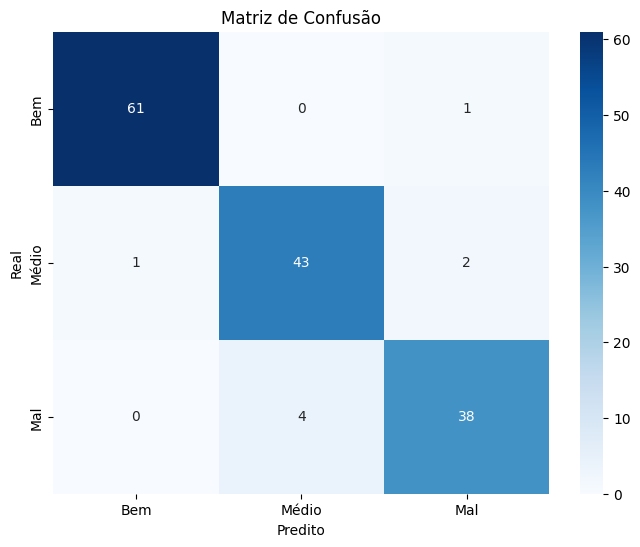

In [ ]:
# Transformar as previsões de volta para as classes originais
y_pred_classes = label_encoder.inverse_transform(np.argmax(y_pred, axis=1))
y_test_classes = label_encoder.inverse_transform(np.argmax(y_test, axis=1))


cm = confusion_matrix(y_test_classes, y_pred_classes)  

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Bem', 'Médio', 'Mal'], yticklabels=['Bem', 'Médio', 'Mal'])
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

### 4.3) Métricas de eficácia

In [ ]:
print("----------------------------------------------------------------")
accuracy = accuracy_score(y_test_classes, y_pred_classes)  
print(f'Acurácia no conjunto de teste: {test_accuracy * 100:.2f}%')

print("----------------------------------------------------------------\n")
classification_rep = classification_report(y_test_classes, y_pred_classes)
print(f'Relatório de Classificação:\n{classification_rep}')


# precision = precision_score(y_test, y_pred)  # Substitua y_test e y_pred pelos seus dados reais e previstos
# print(f'Precisão: {precision}')

# recall = recall_score(y_test, y_pred)  # Substitua y_test e y_pred pelos seus dados reais e previstos
# print(f'Recall: {recall}')

# f1 = f1_score(y_test, y_pred)  # Substitua y_test e y_pred pelos seus dados reais e previstos
# print(f'Medida F: {f1}')

----------------------------------------------------------------
Acurácia no conjunto de teste: 94.67%
----------------------------------------------------------------

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        62
           1       0.91      0.93      0.92        46
           2       0.93      0.90      0.92        42

    accuracy                           0.95       150
   macro avg       0.94      0.94      0.94       150
weighted avg       0.95      0.95      0.95       150

